In [16]:
import io, os 
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, balanced_accuracy_score
plt.rcParams.update( {"font.size": 12})

In [2]:
#Web Scraping
r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
with open(os.path.join("data", "cleveland.txt"), "wb") as f:
    f.write(r.content)

In [3]:
#Data cleanup
heart_df = pd.read_csv(os.path.join("data", "cleveland.txt"), sep=",")
col_headers = ["age", "sex", "chest pain", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]

heart_df.columns = col_headers
heart_df["hasDisease"] = heart_df["num"] > 0
for name in heart_df.columns:
    heart_df = heart_df.drop(heart_df[heart_df[name] == "?"].index)
heart_df = heart_df.drop("num", 1)     
heart_df

,age,sex,chest pain,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hasDisease
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,True
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,True
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,False
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,False
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,True
297,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,True
298,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,True
299,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,True


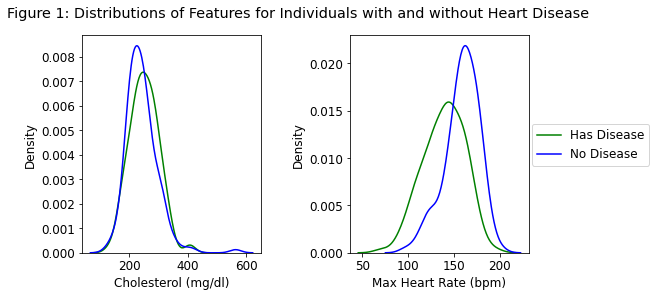

In [4]:
#Figure 1
disease_chol = heart_df.chol[heart_df.hasDisease == 1]
no_disease_chol = heart_df.chol[heart_df.hasDisease == 0]
disease_mhr = heart_df.thalach[heart_df.hasDisease == 1]
no_disease_mhr = heart_df.thalach[heart_df.hasDisease == 0]

fig, axes = plt.subplots(1, 2,figsize=(8,4))
plt.subplots_adjust(wspace = .5)
sns.kdeplot(ax=axes[0],x=disease_chol, c="green")
sns.kdeplot(ax=axes[0],x=no_disease_chol, c="blue")
sns.kdeplot(ax=axes[1],x=disease_mhr, c="green")
sns.kdeplot(ax=axes[1],x=no_disease_mhr , c="blue")
fig.legend(labels=["Has Disease", "No Disease"], bbox_to_anchor=(1.12, 0.5), loc="center right")


plt.setp(axes[0], xlabel="Cholesterol (mg/dl)")
plt.setp(axes[1], xlabel="Max Heart Rate (bpm)")
fig.suptitle("Figure 1: Distributions of Features for Individuals with and without Heart Disease")
plt.savefig("fig1.png",bbox_inches= "tight", dpi=300)

In [5]:
#Stats
print("avg and std of cholesterol of those with heart disease: ",disease_chol.mean(), disease_chol.std())
print("avg and std of cholesterol of those without heart disease: ",no_disease_chol.mean(),no_disease_chol.std())
print("avg and std of max heart rate of those with heart disease: ",disease_mhr.mean(), disease_mhr.std())
print("avg and std of max heart rate of those without heart disease: ",no_disease_mhr.mean(),no_disease_mhr.std())

avg and std of cholesterol of those with heart disease:  251.85401459854015 49.67993738540169
avg and std of cholesterol of those without heart disease:  243.55974842767296 53.92089743024634
avg and std of max heart rate of those with heart disease:  139.1094890510949 22.710673453413925
avg and std of max heart rate of those without heart disease:  158.63522012578616 19.091194001439643


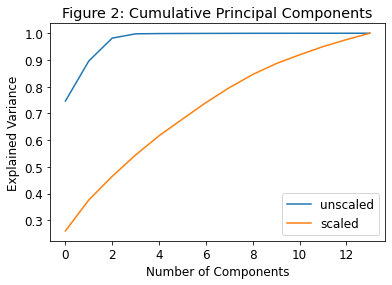

In [6]:
#Figure 2
heart2_df = heart_df.copy()
pca = PCA()
pipePCA = Pipeline([
    ("std", StandardScaler()),
    ("pca", PCA())
])
pca.fit(heart2_df)
pipePCA.fit(heart2_df)

plt.plot(np.cumsum(pca.explained_variance_ratio_), label = "unscaled")
plt.plot(np.cumsum(pipePCA["pca"].explained_variance_ratio_), label = "scaled")
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title("Figure 2: Cumulative Principal Components")
plt.legend()
plt.savefig("fig2.png",bbox_inches= "tight",dpi=300)

In [7]:
print("Unscaled:", np.cumsum(pca.explained_variance_ratio_))

Unscaled: [0.7463524  0.89620009 0.98181772 0.99778416 0.99881199 0.9991449
 0.99939641 0.99961291 0.99979002 0.99984883 0.99990014 0.99994064
 0.99997368 1.        ]


In [8]:
print("Scaled:",np.cumsum(pipePCA["pca"].explained_variance_ratio_))

Scaled: [0.26011075 0.37619478 0.46447767 0.54455637 0.61625108 0.67876038
 0.74033166 0.79622745 0.84558    0.88632284 0.9191663  0.94985622
 0.97617588 1.        ]


In [9]:
#Train Test Splitting
test_col = heart_df.columns.values.tolist()
test_col = test_col[:-1]
test_col
train, test = train_test_split(heart_df, random_state=0)

In [10]:
#Model Creation
heart_pipe = Pipeline([
    ("oh_poly", make_column_transformer((OneHotEncoder(), [ "sex","fbs","chest pain", "restecg",  "exang", "slope", "thal", "ca"]),
                                        (PolynomialFeatures(degree=1, include_bias=True),
                                         ["age", "trestbps", "chol", "thalach", "oldpeak"]),remainder="passthrough")),
    ("std", StandardScaler()),
    ("lg", LogisticRegression())
])

In [11]:
#Score
heart_pipe.fit(train[test_col], train["hasDisease"]) 
print("accuracy score:", heart_pipe.score(test[test_col], test["hasDisease"]))

accuracy score: 0.8513513513513513


Text(0, 0.5, 'Coefficient')

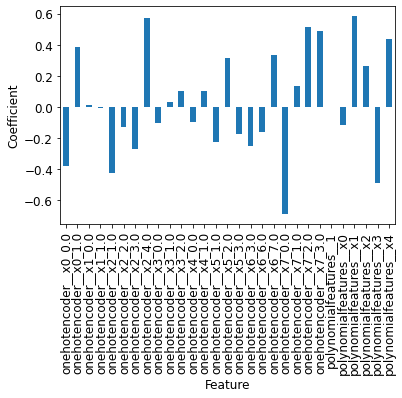

In [12]:
#Unfiltered Plot
feature_names = heart_pipe["oh_poly"].get_feature_names()
coef = pd.Series(heart_pipe["lg"].coef_[0], index = feature_names)
coef.plot.bar()


plt.xlabel("Feature")
plt.ylabel("Coefficient")

values: [0.38304581693503775, -0.3830458169350378, -0.4268097774741057, 0.4341337948271734, 0.48965402196091024, -0.4906283165622325, 0.5145571849436932, 0.5716405532085808, 0.583136951784175, -0.6907041172220243]


<AxesSubplot:xlabel='Feature'>

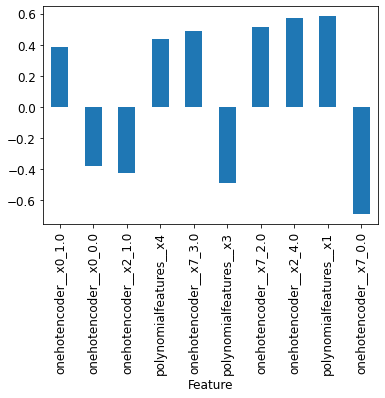

In [13]:
#Plot Preview
coef_df = pd.DataFrame(coef)
coef_df = coef_df.reset_index(drop=False)
coef_df.columns = ["Feature", "Coefficient"]

coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=True).index)

coef_df = coef_df.set_index("Feature")
top = coef_df.tail(10)
full_names = ["slope 2 - presence of flat slope","thal 7 - presence of reversible defect", "sex 0 - female","sex 1 - male","oldpeak - ST depression induced by exercise","chest pain 1 - typical angina/chest pain","thalach - max heart rate","chest pain 4 - asymtomatic chest pain","trestbps - resting blood pressure","ca  0 - fewest number of vessels colored by flouroscopy" ]
short_names = ["Presence of Flat Slope","Presence of Reversible Defect", "Female","Male","ST depression induced by Exercise","Typical Angina/Chest Pain","Max Heart Rate","asymtomatic chest pain","resting blood pressure","Fewest Vessels via Flouroscopy" ]
top_coef = pd.Series(top["Coefficient"].tolist(), index = short_names)
print("values:", top["Coefficient"].tolist())
top.plot.bar(legend=False)

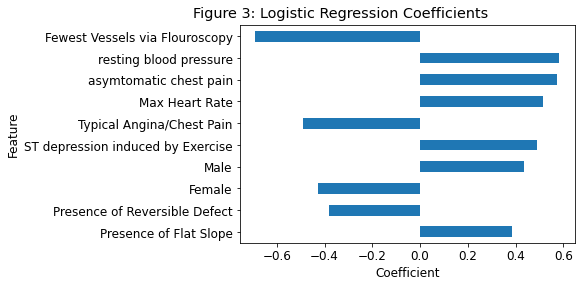

In [14]:
#Figure 3
fig, ax = plt.subplots()
top_coef.plot.barh()
plt.ylabel("Feature", fontsize=12)
plt.xlabel("Coefficient", fontsize=12)
ax.set_title("Figure 3: Logistic Regression Coefficients", x =0.3, y=1.1, pad=-14)

plt.savefig("fig3.png", bbox_inches= "tight",dpi=300)

In [15]:
#Recall and Precision Score
actual = test["hasDisease"].tolist()
predictions = heart_pipe.predict(test[test_col]).tolist()
confusion_matrix(actual, predictions)
print("recall score:", recall_score(actual, predictions))
print("precision score:", precision_score(actual, predictions))

recall score: 0.7878787878787878
precision score: 0.8666666666666667
